In [1]:
import pandas as pd
import numpy as np

In [2]:
dct = {
    "Component" : ["C1","C2","C3","C4","C5","C6","C7+"],
    "yi" : [0.80,0.04,0.03,0.03,0.02,0.01,0.07],
    "Pc" : [666.4,706.5,616,527.9,488.6,453,285],
    "Tc" : [343.33,549.92,666.06,765.62,845.8,923,1160],
    "wi" : [0.0104,0.0979,0.1522,0.1852,0.228,0.25,0.5831],
    "MW" : [16,30,44,58,72,86,220]
}
df = pd.DataFrame(dct)

In [3]:
T = 180+460 #(F)+460, Rankine
R = 10.731557089016 #psi.ft3/(lbmol.R)

In [4]:
#Kappa Calculation
wi = np.asarray(df['wi'],dtype=float)
kp = 0.37464+1.54226*wi-0.26992*wi**2

In [5]:
print(kp)

[0.39065031 0.52304023 0.60311932 0.65100856 0.71224376 0.743335
 1.18215749]


In [6]:
pc = np.asarray(df['Pc'],dtype=float)
tc = np.asarray(df['Tc'],dtype=float)
tr = T/tc

alph = (1+kp*(1-np.sqrt(tr)))**2
ai = 0.45724*R**2*tc**2/pc
bi = 0.0778*R*tc/pc

In [7]:
print(alph)
print(ai)
print(bi)

[0.7349428  0.91926935 1.02397485 1.11471108 1.19395335 1.26418345
 1.70060626]
[  9314.47143533  22540.13744558  37924.1355756   58471.54564846
  77099.50602575  99031.85102226 248622.72089599]
[0.43014918 0.64987478 0.90276555 1.21088792 1.44529518 1.70116264
 3.3982511 ]


In [8]:
l = len(df)
y = np.asarray(df['yi'],dtype=float)

aam = 0
for i in range(l):
    for j in range(l):
        aam = aam + y[i]*y[j]*np.sqrt(ai[i]*ai[j]*alph[i]*alph[j])
bm  = sum(y*bi)
print("aam = %f"%aam,"bm = %f"%bm)

aam = 19780.246504 bm = 0.717319


In [16]:
P = np.arange(200,3100,100)
P

array([ 200,  300,  400,  500,  600,  700,  800,  900, 1000, 1100, 1200,
       1300, 1400, 1500, 1600, 1700, 1800, 1900, 2000, 2100, 2200, 2300,
       2400, 2500, 2600, 2700, 2800, 2900, 3000])

In [18]:
A = aam*P/(R**2*T**2)
B = bm*P/(R*T)
B

array([0.02088813, 0.0313322 , 0.04177627, 0.05222034, 0.0626644 ,
       0.07310847, 0.08355254, 0.0939966 , 0.10444067, 0.11488474,
       0.1253288 , 0.13577287, 0.14621694, 0.15666101, 0.16710507,
       0.17754914, 0.18799321, 0.19843727, 0.20888134, 0.21932541,
       0.22976947, 0.24021354, 0.25065761, 0.26110168, 0.27154574,
       0.28198981, 0.29243388, 0.30287794, 0.31332201])

In [19]:
# t# as polynomial term (t1)x^3+(t2)x^2+(t3)x+(t4)
t1 = 1
t2 = -(1-B)
t3 = A-3*B**2-2*B
t4 = -(A*B-B**2-B**3)

In [71]:
rt = []
for i in range(len(P)):
    p = np.poly1d([t1,t2[i],t3[i],t4[i]])
    rt = rt + [p.roots]

In [72]:
#Real and Imaginer Number Identification
cond = []
zEOS = []
for j in range(len(P)):
    count_real = sum(rt[j].imag == 0)
    if count_real == 1: #one phase
        cond += [1]
        zEOS += [rt[j][0].real]
    elif count_real == 3: #two phase, zfactor vapour = max(z)
        cond += [2]

In [73]:
sum(cond) == len(P) #if True, every P,T indicate one phase fluid state

True

In [ ]:
zEOS

In [158]:
MW = np.asarray(df["MW"],dtype=int)
MWa = sum(y*MW)
GamG = MWa/28.97

In [159]:
GamG

1.19986192613048

In [65]:
Ppc = sum(y*pc)
Tpc = sum(y*tc)
Ppc,Tpc

(629.9490000000001, 446.9572)

In [66]:
#Z Correlation
Tpr = T/Tpc
Ppr = P/Ppc
Az = 1.39*(Tpr-0.92)**0.5-0.36*Tpr-0.1
Cz = 0.132 - 0.32*np.log10(Tpr)
Ez = 9*(Tpr-1)
Fz = 0.3106 - 0.49*Tpr+0.1824*Tpr**2
Dz = 10**Fz
Bz = (0.62-0.23*Tpr)*Ppr +(0.066/(Tpr-0.86)-0.037)*Ppr**2+0.32*Ppr**6/10**Ez

zCorr = Az + (1-Az)/np.exp(Bz) + Cz * Ppr**Dz
zCorr

array([0.96804814, 0.9504324 , 0.93233361, 0.91404999, 0.89584517,
       0.87795484, 0.86058831, 0.8439287 , 0.8281331 , 0.81333296,
       0.79963493, 0.78712213, 0.7758559 , 0.76587781, 0.75721192,
       0.74986718, 0.7438398 , 0.73911555, 0.7356719 , 0.73347989,
       0.73250564, 0.73271153, 0.734057  , 0.7364989 , 0.73999148,
       0.74448612, 0.7499307 , 0.75626899, 0.76344004])

In [110]:
print(plt.style.available)

['Solarize_Light2', '_classic_test_patch', 'bmh', 'classic', 'dark_background', 'fast', 'fivethirtyeight', 'ggplot', 'grayscale', 'seaborn', 'seaborn-bright', 'seaborn-colorblind', 'seaborn-dark', 'seaborn-dark-palette', 'seaborn-darkgrid', 'seaborn-deep', 'seaborn-muted', 'seaborn-notebook', 'seaborn-paper', 'seaborn-pastel', 'seaborn-poster', 'seaborn-talk', 'seaborn-ticks', 'seaborn-white', 'seaborn-whitegrid', 'tableau-colorblind10']


In [133]:
import matplotlib.pyplot as plt

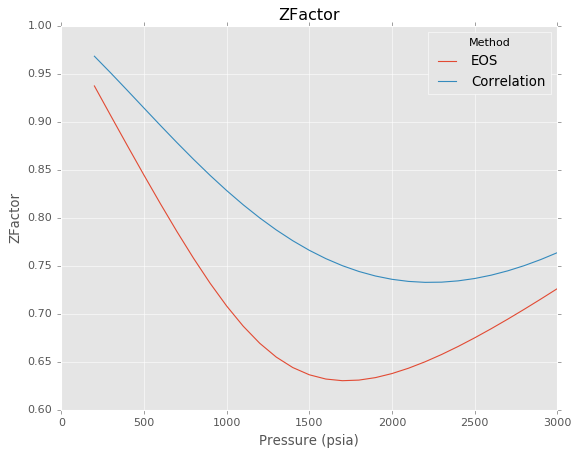

In [146]:
plt.plot(P,zEOS,label='EOS')
plt.plot(P,zCorr,label='Correlation')
plt.title("ZFactor")
plt.xlabel('Pressure (psia)')
plt.ylabel('ZFactor')
plt.legend(title='Method')
plt.style.use('ggplot')
plt.show()

In [154]:
#FVG Gas Calculation
Bg0 = zEOS/P*T*0.0283
Bg1 = zCorr/P*T*0.0283
# ft3/scf

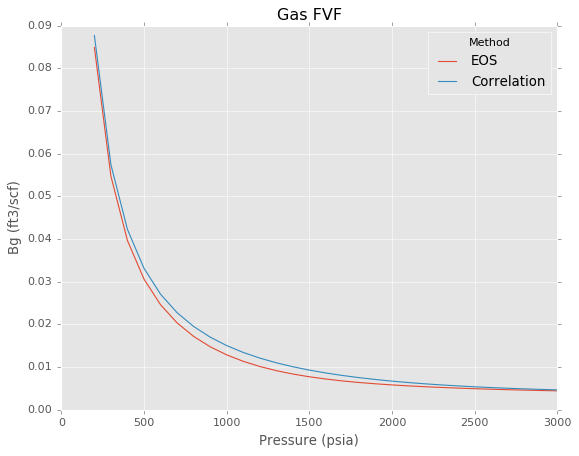

In [155]:
plt.plot(P,Bg0,label='EOS')
plt.plot(P,Bg1,label='Correlation')
plt.title("Gas FVF")
plt.xlabel('Pressure (psia)')
plt.ylabel('Bg (ft3/scf)')
plt.legend(title='Method')
plt.style.use('ggplot')
plt.show()

In [161]:
#Density Gas Calculation
rho_g0 = P/zEOS*2.7*GamG/T
rho_g1 = P/zCorr*2.7*GamG/T
#lbm/ft3

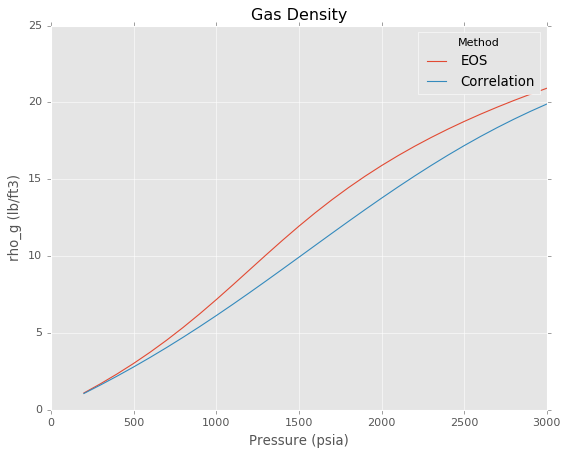

In [162]:
plt.plot(P,rho_g0,label='EOS')
plt.plot(P,rho_g1,label='Correlation')
plt.title("Gas Density")
plt.xlabel('Pressure (psia)')
plt.ylabel('rho_g (lb/ft3)')
plt.legend(title='Method')
plt.style.use('ggplot')
plt.show()

In [164]:
#Viscosity Gas Calculation
Am = (9.379*0.01607*MWa)*T**1.5/(209.2+19.26*MWa+T)
Bm = 3.448 + 986.4/T + 0.01009*MWa
Cm = 2.447 - 0.2224*Bm

mug0 = Am*np.exp(Bm*(rho_g0/62.428)**Cm)*1e-4
mug1 = Am*np.exp(Bm*(rho_g1/62.428)**Cm)*1e-4
#cP

array([0.00576858, 0.00590781, 0.00607629, 0.0062767 , 0.00651296,
       0.00678987, 0.00711269, 0.00748659, 0.00791574, 0.00840228,
       0.00894534, 0.00954058, 0.0101807 , 0.01085655, 0.01155863,
       0.01227821, 0.01300801, 0.01374234, 0.01447696, 0.01520888,
       0.01593599, 0.01665693, 0.01737081, 0.0180771 , 0.01877553,
       0.01946598, 0.02014848, 0.02082311, 0.02149002])

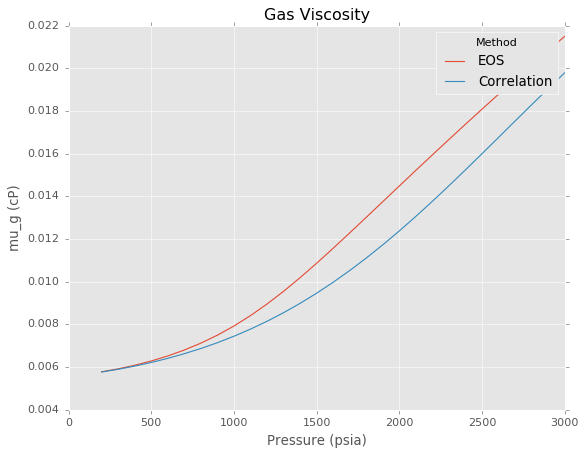

In [166]:
plt.plot(P,mug0,label='EOS')
plt.plot(P,mug1,label='Correlation')
plt.title("Gas Viscosity")
plt.xlabel('Pressure (psia)')
plt.ylabel('mu_g (cP)')
plt.legend(title='Method')
plt.style.use('ggplot')
plt.show()

In [170]:
dct0 = {
    "Pressure (psia)" : P,
    "ZFactor" : zEOS,
    "FVF Gas (cuft/scf)" : Bg0,
    "Gas Density (lbm/cuft)" : rho_g0,
    "Gas Viscosity (cP)" : mug0
}
dct1 = {
    "Pressure (psia)" : P,
    "ZFactor" : zCorr,
    "FVF Gas (cuft/scf)" : Bg1,
    "Gas Density (lbm/cuft)" : rho_g1,
    "Gas Viscosity (cP)" : mug1
}
df_result0 = pd.DataFrame(dct0)
df_result1 = pd.DataFrame(dct1)

with pd.ExcelWriter("output.xlsx") as writer:
    df_result0.to_excel(writer, index=False, sheet_name="EOS")
    df_result1.to_excel(writer, index=False,sheet_name="Correlation")
print("Result is saved on output.xlsx, please check your directory")